In [4]:
!pip install lifetimes -q

In [5]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import lifetimes

In [6]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style="ticks")
sns.set_context("poster", font_scale = 0.5, rc={"grid.linewidth": 5})
plt.rcParams['figure.figsize'] = (8,4) 
plt.rcParams["figure.dpi"] = 140 

In [7]:
root = '../input/brazilian-ecommerce/'
customers = pd.read_csv(root+'olist_customers_dataset.csv')
orders = pd.read_csv(root+'olist_orders_dataset.csv')
payments = pd.read_csv(root+'olist_order_payments_dataset.csv')

In [8]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [9]:
customers.drop(columns=[i for i in customers.columns if i not in ['customer_id','customer_unique_id']], inplace=True)
customers.set_index('customer_id', inplace=True)

In [10]:
customers.head(1)

,customer_unique_id
customer_id,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0


In [11]:
orders.drop(columns=[i for i in orders.columns if i not in ['customer_id', 'order_id', 'order_purchase_timestamp']], inplace=True)
orders.set_index('customer_id', inplace=True)
orders.drop_duplicates(inplace=True)

In [12]:
orders.head(1)

,order_id,order_purchase_timestamp
customer_id,,
9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33


In [13]:
payments.drop(columns=[i for i in payments.columns if i not in ['order_id', 'payment_value']], inplace=True)
payments.set_index('order_id', inplace=True)
payments.drop_duplicates(inplace=True)

In [14]:
payments.head(1)

,payment_value
order_id,
b81ef226f3fe1789b1e8b2acac839d17,99.33


In [15]:
df = pd.concat([orders,customers], axis=1, join='inner')
df.reset_index(inplace=True)

In [16]:
df['Order_Date'] = pd.to_datetime(pd.to_datetime(df.order_purchase_timestamp).dt.date)
df.head(1)

,customer_id,order_id,order_purchase_timestamp,customer_unique_id,Order_Date
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10-02


In [17]:
df.drop(columns=[i for i in df.columns if i not in ['customer_unique_id','Order_Date']], inplace=True)

In [18]:
df.Order_Date.describe()

count                   99441
unique                    634
top       2017-11-24 00:00:00
freq                     1176
first     2016-09-04 00:00:00
last      2018-10-17 00:00:00
Name: Order_Date, dtype: object

In [19]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'customer_unique_id', 'Order_Date',
                                        calibration_period_end='2018-06-30',
                                        observation_period_end='2018-09-28' )   
print(summary_cal_holdout.head())

                                  frequency_cal  recency_cal  T_cal  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2            0.0          0.0   51.0   
0000b849f77a49e4a4ce2b2a4ca5be3f            0.0          0.0   54.0   
0000f46a3911fa3c0805444483337064            0.0          0.0  477.0   
0000f6ccb0745a6a4b88665a16c9f078            0.0          0.0  261.0   
0004aac84e0df4da2b147fca70cf8255            0.0          0.0  228.0   

                                  frequency_holdout  duration_holdout  
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2                0.0              90.0  
0000b849f77a49e4a4ce2b2a4ca5be3f                0.0              90.0  
0000f46a3911fa3c0805444483337064                0.0              90.0  
0000f6ccb0745a6a4b88665a16c9f078                0.0              90.0  
0004aac84e0df4da2b147fca70cf8255                0.0              90.0 

In [20]:

from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'],
       verbose=True)

Optimization terminated successfully.
         Current function value: 0.085065
         Iterations: 42
         Function evaluations: 43
         Gradient evaluations: 43


<lifetimes.ModifiedBetaGeoFitter: fitted with 83748 subjects, a: 0.22, alpha: 218.09, b: 0.12, r: 0.10>

# **Predictions for each customer**

In [21]:
t = 90 # days to predict in the future 
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      summary_cal_holdout['frequency_cal'], 
                                                                                      summary_cal_holdout['recency_cal'], 
                                                                                      summary_cal_holdout['T_cal'])

summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'], 
                                                                         summary_cal_holdout['recency_cal'], 
                                                                         summary_cal_holdout['T_cal'])
summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive'] / summary_cal_holdout['p_alive'].max(), 2)

In [22]:
display(summary_cal_holdout.sample(2).T)

customer_unique_id,94539fc0e5ccdbfa53cd3903116564dc,9410c05c403cf6b73c071fa50c8ae641
frequency_cal,0.000000,0.000000
recency_cal,0.000000,0.000000
T_cal,12.000000,376.000000
frequency_holdout,0.000000,0.000000
duration_holdout,90.000000,90.000000
predicted_purchases,0.012826,0.004756
p_alive,0.360000,0.340000


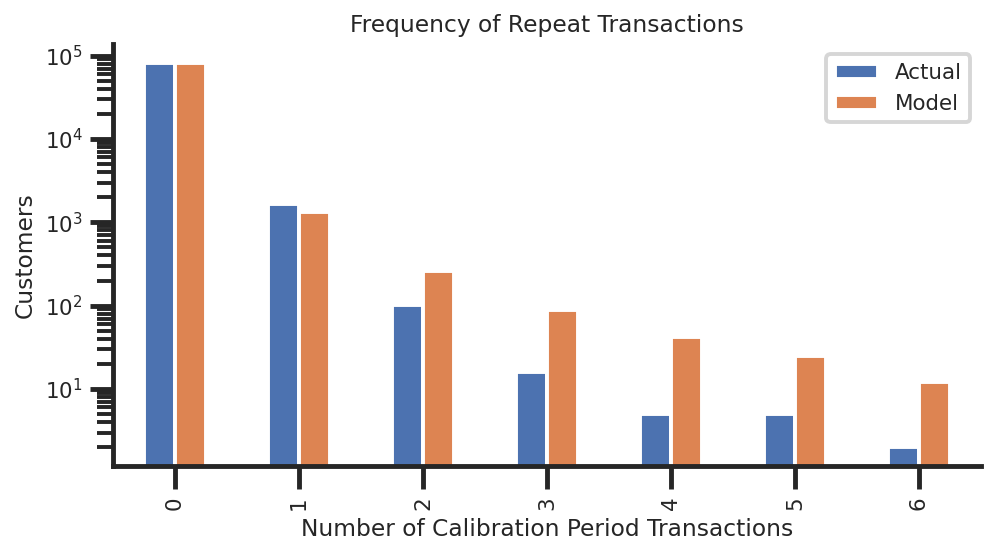

In [23]:
from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log')
sns.despine();

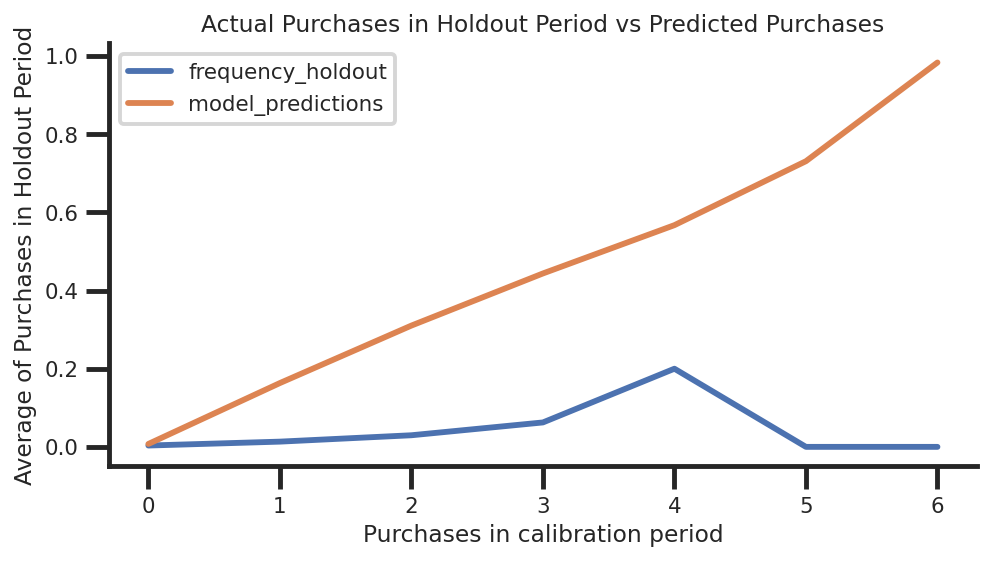

In [24]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)
sns.despine();

In [25]:
from lifetimes.plotting import plot_history_alive
from datetime import date
from pylab import figure, text, scatter, show

In [26]:
individual = summary_cal_holdout.iloc[4942]

In [27]:
individual

frequency_cal           0.000000
recency_cal             0.000000
T_cal                  82.000000
frequency_holdout       0.000000
duration_holdout       90.000000
predicted_purchases     0.009732
p_alive                 0.350000
Name: 0f0bf5903614594ea042384fa3c86770, dtype: float64

In [31]:
t = 365*50

today = date.today()
two_year_ago = today.replace(year=today.year - 2)
one_year_from_now = today.replace(year=today.year + 1)

cust = df.loc[df['customer_unique_id'] == individual.name]

from lifetimes.utils import calculate_alive_path

t = (today - sp_trans.Order_Date.min().date()).days
p_alive_today = pd.DataFrame(calculate_alive_path(mbgnbd, cust, 'Order_Date', t, freq='D'))[0].tail(1).values
p_alive_today = np.round(p_alive_today[0], 2)
print('Probability that customer is alive today is', p_alive_today)

Probability that customer is alive today is [0.31]


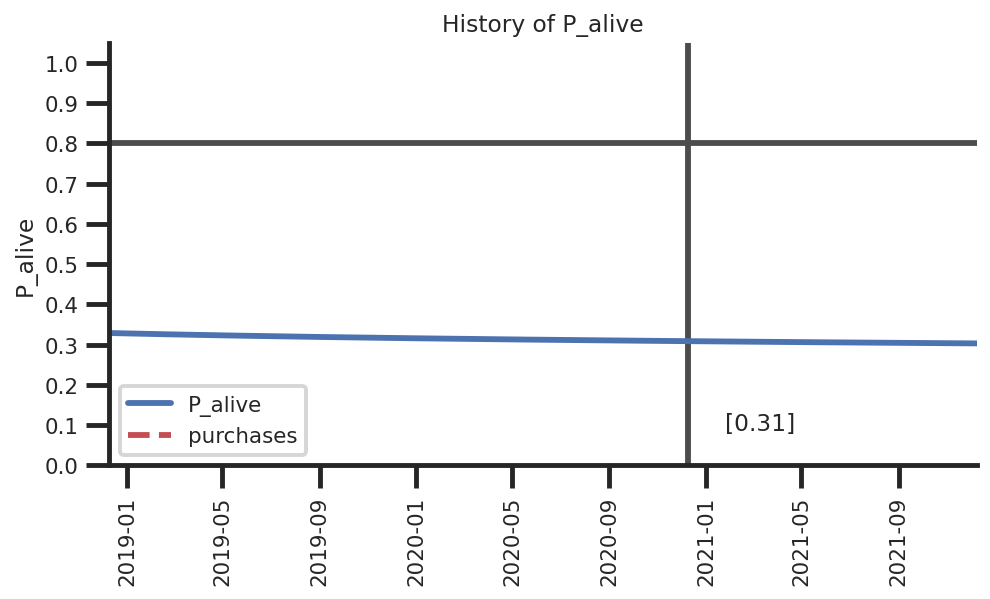

In [36]:
t2 = (one_year_from_now - sp_trans.Order_Date.min().date()).days
ax = plot_history_alive(mbgnbd, t2, cust, 'Order_Date', start_date=two_year_ago) 
ax.vlines(x=today, ymin=0, ymax=1.05, colors='#4C4C4C')
ax.hlines(y=0.8, xmin=two_year_ago, xmax=one_year_from_now, colors='#4C4C4C')

ax.set_xlim(two_year_ago, one_year_from_now)
ax.set_ylim(0, 1.05)

plt.xticks(rotation=90)
text(0.75, 0.1, p_alive_today, ha='center', va='center', transform=ax.transAxes)

sns.despine()

#  Predict Transactions with Time

In [37]:
# Get expected and actual repeated cumulative transactions.

from lifetimes.utils import expected_cumulative_transactions

t3 = (df.Order_Date.max() - df.Order_Date.min()).days
new_df = expected_cumulative_transactions(mbgnbd, df, 'Order_Date', 'customer_unique_id', t3)

In [40]:
new_df.tail(2)

,actual,predicted
771,2383,3913.923334
772,2384,3926.824743


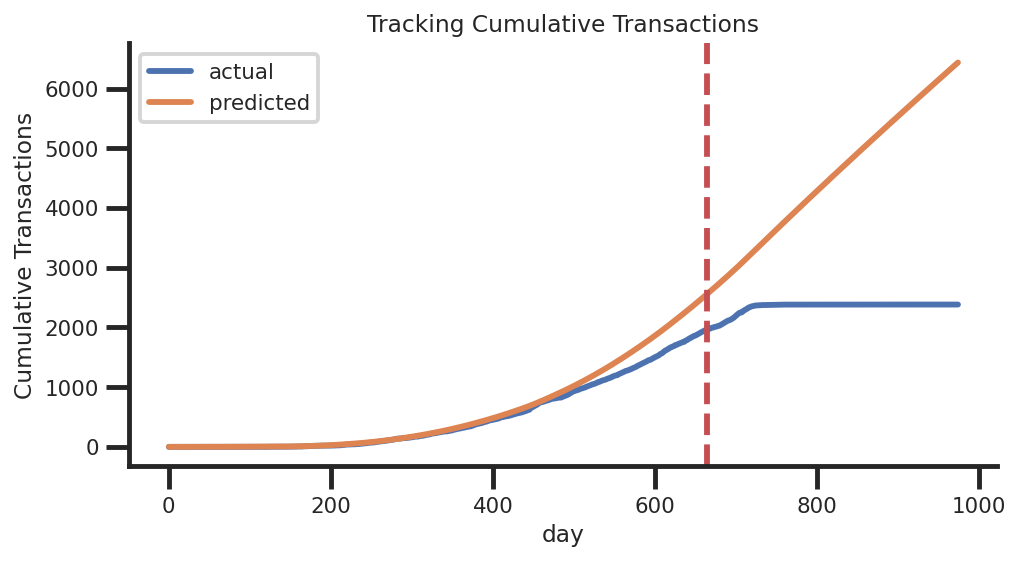

In [41]:
# Calibration period = 2016-09-04 to 2017-09-30
from datetime import datetime

cal = datetime.strptime('2018-06-30', '%Y-%m-%d')

from lifetimes.plotting import plot_cumulative_transactions
t4 = (df.Order_Date.max() - df.Order_Date.min()).days
t_cal = (cal - df.Order_Date.min()).days
plot_cumulative_transactions(mbgnbd, df, 'Order_Date', 'customer_unique_id', t, t_cal, freq='D')
sns.despine()

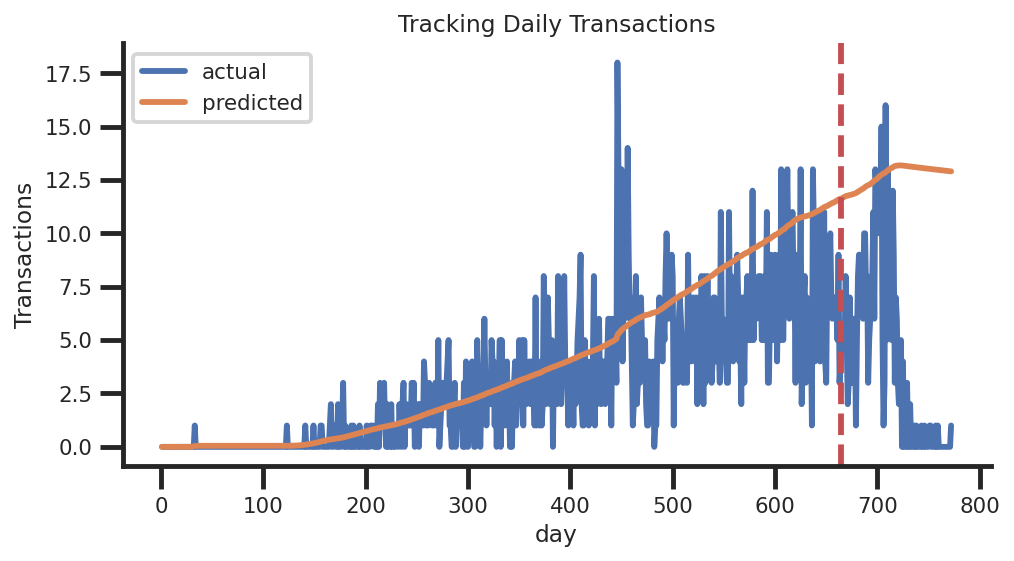

In [42]:
from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(mbgnbd, df, 'Order_Date', 'customer_unique_id', t4, t_cal, freq='D')
sns.despine()